In [ ]:
!pip install pyyaml==5.4.1
!pip install darts
!pip install -U matplotlib

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime, timedelta, date

import seaborn as sns
sns.set_context('talk')
%matplotlib inline

#Usaremos la libreria DARTS

from darts import TimeSeries
from darts.utils.utils import SeasonalityMode
from darts.utils.statistics import check_seasonality
from darts.metrics import mape, mase
from darts.models import AutoARIMA, ExponentialSmoothing, Prophet, Theta, LinearRegressionModel

In [ ]:
sns.set_context("notebook", rc={"grid.linewidth": 0.6, "lines.linewidth": 1})
sns.set_style("whitegrid")
sns.set_palette("Accent_r")

# Combinación de dataset de ConcientizAR y SMN

En esta notebook vamos a intentar unir los datasets con los datos del medidor (datos anuales a los cuales hemos tenido que eliminar columnas que no usaremos, con el objeto de reducir el tamaño del mismo) junto con la información histórica del clima obtenidos del Servicio Meteorológico Nacional que cuenta con registros por cada hora en punto.  
  
La única manera de realizar esta combinación es mediante el dato de fecha y hora presente en ambos datasets, aunque no vaya a haber una coincidencia exacta para tales registros.  
  
Por lo tanto seguiremos la siguiente estrategia:  
 1. Unir por el valor de fecha y hora más próximo. Es decir, dado que el SMN provee datos a la hora en punto, deberemos buscar el registro más cercano a esa hora en el otro dataset y asignar ahí la información del clima.  
 2. Rellenar todos los registros intermedios con una interpolación entre los valores de una hora y la siguiente.  
   

In [ ]:
# Cargamos los datasets
#URL = 'https://drive.google.com/file/d/1FOQmYdo3aMLEv6FTxsBMiRYGneuc8cXS/view?usp=sharing'
URL = 'https://drive.google.com/file/d/1_8CzOYESqy1D3IoWZO9VyTLsJ51OLJA-/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+URL.split('/')[-2]
toma_df = pd.read_csv(path)

#URL = 'https://drive.google.com/file/d/1Z7-vfbV8jjYl5ARZvLXg5ptAEOjzajyr/view?usp=sharing'
URL = 'https://drive.google.com/file/d/1Uu0AzBpjgT0L45btRoznMOlkK0O-1rEM/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+URL.split('/')[-2]
clima_df = pd.read_csv(path)
#toma_df = pd.read_csv('./data/tomaselli_2020_10_v1.csv')
#clima_df = pd.read_csv('./data/smn_20201030_a_20201130.csv')

In [ ]:
# Creamos una columna con el mismo nombre en cada dataset y lo ordenamos
toma_df['FECHA_HORA'] = pd.to_datetime(toma_df.createdAt).dt.tz_localize(None)
clima_df['FECHA_HORA'] = pd.to_datetime(clima_df.FECHA_HORA).dt.tz_localize(None)
toma_df.sort_values('FECHA_HORA', inplace=True)
clima_df.sort_values('FECHA_HORA', inplace=True)

#Dataset CONCIENTIZAR

In [ ]:
toma_df.shape

(1382426, 5)

In [ ]:
toma_df.columns

Index(['Active_Energy_Delivered', 'Power_Factor_Total', 'Temperature',
       'createdAt', 'FECHA_HORA'],
      dtype='object')

In [ ]:
toma_df[:5]

,Active_Energy_Delivered,Power_Factor_Total,Temperature,createdAt,FECHA_HORA
0,119489.99,0.97,46.16,2021-01-01T00:00:09.967Z,2021-01-01 00:00:09.967
1,119490.03,0.97,46.16,2021-01-01T00:00:22.937Z,2021-01-01 00:00:22.937
2,119490.05,0.96,46.46,2021-01-01T00:00:30.739Z,2021-01-01 00:00:30.739
3,119490.05,0.96,46.46,2021-01-01T00:00:45.201Z,2021-01-01 00:00:45.201
4,119490.08,0.96,47.08,2021-01-01T00:00:55.601Z,2021-01-01 00:00:55.601


Verificamos  valores 0 en Active_Energy_Delivered, Power_Factor_Total y Temperature

In [ ]:
print('Cantidad de CEROS en columna "Active_Energy_Delivered" : ', (toma_df['Active_Energy_Delivered'] == 0).sum())
print('Cantidad de CEROS en columna "Power_Factor_Total" : ', (toma_df['Power_Factor_Total'] == 0).sum())
print('Cantidad de CEROS en columna "Temperature" : ', (toma_df['Temperature'] == 0).sum())

Cantidad de CEROS en columna "Active_Energy_Delivered" :  566
Cantidad de CEROS en columna "Power_Factor_Total" :  570
Cantidad de CEROS en columna "Temperature" :  563


Borramos registros con 0 en algunas de las 3 columnas ya que son valores incorrectos

In [ ]:
columns = ['Active_Energy_Delivered', 'Power_Factor_Total', 'Temperature']
toma_df = toma_df.replace(0, np.nan).dropna(axis=0, how='any', subset=columns)



In [ ]:
#Verifico  valores 0 en Active_Energy_Delivered, Power_Factor_Total y Temperature
print('Cantidad de CEROS en columna "Active_Energy_Delivered" : ', (toma_df['Active_Energy_Delivered'] == 0).sum())
print('Cantidad de CEROS en columna "Power_Factor_Total" : ', (toma_df['Power_Factor_Total'] == 0).sum())
print('Cantidad de CEROS en columna "Temperature" : ', (toma_df['Temperature'] == 0).sum())

Cantidad de CEROS en columna "Active_Energy_Delivered" :  0
Cantidad de CEROS en columna "Power_Factor_Total" :  0
Cantidad de CEROS en columna "Temperature" :  0


In [ ]:
toma_df.shape

(1381854, 5)

Truncamos las mediciones a 1 registro por minuto

In [ ]:
toma_df['Fecha_Hora_Min'] = toma_df['FECHA_HORA'].dt.floor('min')
toma_df = toma_df.groupby('Fecha_Hora_Min').agg(TEMP = ('Temperature','max'),Power_Factor_Total = ('Power_Factor_Total','min'),Active_Energy_Delivered = ('Active_Energy_Delivered','last')).reset_index()

In [ ]:
toma_df[:5]

,Fecha_Hora_Min,TEMP,Power_Factor_Total,Active_Energy_Delivered
0,2021-01-01 00:00:00,47.08,0.96,119490.08
1,2021-01-01 00:01:00,47.08,0.93,119490.14
2,2021-01-01 00:02:00,46.77,0.94,119490.23
3,2021-01-01 00:03:00,46.77,0.94,119490.29
4,2021-01-01 00:04:00,46.46,0.94,119490.36


Verificamos faltantes de informacion

In [ ]:
toma_df.set_index('Fecha_Hora_Min',drop=True,inplace=True)
#df.index = pd.to_datetime(df.index, format = '%Y-%m-%d %H:%M:%S')
idx = pd.date_range(toma_df.index.min(), toma_df.index.max(), freq='min')
print('Registros faltantes: ',idx.difference(toma_df.index))

Registros faltantes:  DatetimeIndex(['2021-01-04 08:01:00', '2021-01-04 08:02:00',
               '2021-01-04 08:03:00', '2021-01-04 08:04:00',
               '2021-01-04 08:06:00', '2021-01-04 08:07:00',
               '2021-01-04 08:09:00', '2021-01-04 08:10:00',
               '2021-01-04 08:13:00', '2021-01-04 08:14:00',
               ...
               '2021-12-31 11:54:00', '2021-12-31 11:55:00',
               '2021-12-31 11:56:00', '2021-12-31 11:57:00',
               '2021-12-31 11:58:00', '2021-12-31 11:59:00',
               '2021-12-31 12:00:00', '2021-12-31 12:01:00',
               '2021-12-31 12:02:00', '2021-12-31 12:03:00'],
              dtype='datetime64[ns]', length=255450, freq=None)


Completamos registros faltantes

In [ ]:

toma_df=toma_df.reindex(idx,fill_value=np.nan)
print('Registros faltantes despues de completamiento: ',idx.difference(toma_df.index))
toma_df['Fecha_Hora_Min'] = toma_df.index
toma_df.reset_index(drop=True,inplace=True)

Registros faltantes despues de completamiento:  DatetimeIndex([], dtype='datetime64[ns]', freq='T')


In [ ]:
toma_df.rename(columns = {'Fecha_Hora_Min': 'FECHA_HORA','TEMP': 'TEMP_INT'}, inplace = True)

In [ ]:
mask = ((toma_df["FECHA_HORA"] >= '2021-02-08 08:37:00') & (toma_df["FECHA_HORA"] <= '2021-07-28 10:57:00'))
toma_df[['FECHA_HORA', 'Power_Factor_Total', 'Active_Energy_Delivered']].loc[mask]

,FECHA_HORA,Power_Factor_Total,Active_Energy_Delivered
55237,2021-02-08 08:37:00,0.74,135192.30
55238,2021-02-08 08:38:00,NaN,NaN
55239,2021-02-08 08:39:00,NaN,NaN
55240,2021-02-08 08:40:00,NaN,NaN
55241,2021-02-08 08:41:00,NaN,NaN
...,...,...,...
300173,2021-07-28 10:53:00,NaN,NaN
300174,2021-07-28 10:54:00,NaN,NaN
300175,2021-07-28 10:55:00,NaN,NaN
300176,2021-07-28 10:56:00,NaN,NaN


Utilizamos el método interpolate() para hacer una interpolación lineal de la columna "Active_Energy_Delivered" entre cada datapoint. Para "TEMP" usaremos la media, al igual que para "Power_Factor_Total"

In [ ]:
toma_df[['Active_Energy_Delivered']] = toma_df[['Active_Energy_Delivered']].interpolate()

In [ ]:
mean_value=toma_df['TEMP_INT'].mean()
toma_df['TEMP_INT'].fillna(value=mean_value, inplace=True)
mean_value=toma_df['Power_Factor_Total'].mean()
toma_df['Power_Factor_Total'].fillna(value=mean_value, inplace=True)

In [ ]:
mask = ((toma_df["FECHA_HORA"] >= '2021-02-08 08:37:00') & (toma_df["FECHA_HORA"] <= '2021-07-28 10:57:00'))
toma_df[['FECHA_HORA', 'Power_Factor_Total', 'Active_Energy_Delivered']].loc[mask]

,FECHA_HORA,Power_Factor_Total,Active_Energy_Delivered
55237,2021-02-08 08:37:00,0.740000,135192.30000
55238,2021-02-08 08:38:00,0.847739,135192.56455
55239,2021-02-08 08:39:00,0.847739,135192.82910
55240,2021-02-08 08:40:00,0.847739,135193.09365
55241,2021-02-08 08:41:00,0.847739,135193.35820
...,...,...,...
300173,2021-07-28 10:53:00,0.847739,199990.10180
300174,2021-07-28 10:54:00,0.847739,199990.36635
300175,2021-07-28 10:55:00,0.847739,199990.63090
300176,2021-07-28 10:56:00,0.847739,199990.89545


#Dataset SMN

In [ ]:
clima_df.columns

Index(['FECHA', 'HORA', 'TEMP', 'HUM', 'PNM', 'DD', 'FF', 'NOMBRE',
       'FECHA_HORA'],
      dtype='object')

In [ ]:
clima_df.shape

(8760, 9)

In [ ]:
clima_df[:5]

,FECHA,HORA,TEMP,HUM,PNM,DD,FF,NOMBRE,FECHA_HORA
0,1012021,0,21.0,51,1012.9,50,6,CORDOBA OBSERVATORIO,2021-01-01 00:00:00
1,1012021,1,21.2,47,1012.6,20,6,CORDOBA OBSERVATORIO,2021-01-01 01:00:00
2,1012021,2,20.7,49,1010.7,340,4,CORDOBA OBSERVATORIO,2021-01-01 02:00:00
3,1012021,3,19.4,55,1011.3,320,4,CORDOBA OBSERVATORIO,2021-01-01 03:00:00
4,1012021,4,19.6,53,1011.2,360,7,CORDOBA OBSERVATORIO,2021-01-01 04:00:00


Verificamos valores NULOS en TEMP

In [ ]:
print('Cantidad de NULOS en columna "TEMP" : ', clima_df.isnull().sum())

Cantidad de NULOS en columna "TEMP" :  FECHA         0
HORA          0
TEMP          0
HUM           0
PNM           0
DD            0
FF            0
NOMBRE        0
FECHA_HORA    0
dtype: int64


Verificamos faltantes de informacion

In [ ]:
clima_df.set_index('FECHA_HORA',drop=True,inplace=True)
#df.index = pd.to_datetime(df.index, format = '%Y-%m-%d %H:%M:%S')
idx = pd.date_range(clima_df.index.min(), clima_df.index.max(), freq='H')
print('Registros faltantes: ',idx.difference(clima_df.index))

Registros faltantes:  DatetimeIndex(['2021-01-26 18:00:00', '2021-02-06 00:00:00',
               '2021-02-06 01:00:00', '2021-02-06 02:00:00',
               '2021-02-06 03:00:00', '2021-02-06 04:00:00',
               '2021-02-06 05:00:00', '2021-02-06 06:00:00',
               '2021-02-06 07:00:00', '2021-02-06 08:00:00',
               '2021-02-06 09:00:00', '2021-02-06 10:00:00',
               '2021-02-06 11:00:00', '2021-02-06 12:00:00',
               '2021-02-06 13:00:00', '2021-02-06 14:00:00',
               '2021-02-06 15:00:00', '2021-02-06 16:00:00',
               '2021-02-06 17:00:00', '2021-02-06 18:00:00',
               '2021-02-06 19:00:00', '2021-02-06 20:00:00',
               '2021-02-06 21:00:00', '2021-02-06 22:00:00',
               '2021-02-06 23:00:00', '2021-06-12 15:00:00',
               '2021-07-31 19:00:00', '2021-08-22 23:00:00',
               '2021-09-08 00:00:00', '2021-10-24 23:00:00',
               '2021-11-23 17:00:00'],
              dtype='dat

In [ ]:
clima_df['FECHA_HORA'] = clima_df.index
clima_df.reset_index(drop=True,inplace=True)

In [ ]:
mask = ((clima_df["FECHA_HORA"] >= '2021-02-05 23:00:00') & (clima_df["FECHA_HORA"] <= '2021-02-07 00:00:00'))
clima_df[['FECHA_HORA','TEMP', 'HUM', 'PNM', 'DD', 'FF', 'FECHA','HORA']].loc[mask]

,FECHA_HORA,TEMP,HUM,PNM,DD,FF,FECHA,HORA
886,2021-02-05 23:00:00,22.0,61,1014.1,360,7,5022021,23
887,2021-02-05 23:00:00,22.0,61,1014.1,360,7,6022021,23
888,2021-02-07 00:00:00,22.9,66,1011.9,360,7,7022021,0


## Unión por la hora más próxima

In [ ]:
# Unimos los datasets usando 15 seg como toleracia máxima para encontrar un valor próximo. 
# Esto es porque el instrumento toma 5 registros por minuto, por lo tanto el valor más cercado
# debería estar cerca de los 13 seg de la hora en punto, y con ello evitamos unir en otros registros.

merged_df = pd.merge_asof(
    toma_df, 
    clima_df, 
    on="FECHA_HORA", 
    direction='backward', 
    tolerance=pd.Timedelta("15sec")
)

In [ ]:
merged_df[['FECHA_HORA','Active_Energy_Delivered','TEMP', 'HUM', 'PNM', 'DD', 'FF']].head(10)

,FECHA_HORA,Active_Energy_Delivered,TEMP,HUM,PNM,DD,FF
0,2021-01-01 00:00:00,119490.08,21.0,51.0,1012.9,50.0,6.0
1,2021-01-01 00:01:00,119490.14,NaN,NaN,NaN,NaN,NaN
2,2021-01-01 00:02:00,119490.23,NaN,NaN,NaN,NaN,NaN
3,2021-01-01 00:03:00,119490.29,NaN,NaN,NaN,NaN,NaN
4,2021-01-01 00:04:00,119490.36,NaN,NaN,NaN,NaN,NaN
5,2021-01-01 00:05:00,119490.45,NaN,NaN,NaN,NaN,NaN
6,2021-01-01 00:06:00,119490.51,NaN,NaN,NaN,NaN,NaN
7,2021-01-01 00:07:00,119490.59,NaN,NaN,NaN,NaN,NaN
8,2021-01-01 00:08:00,119490.68,NaN,NaN,NaN,NaN,NaN
9,2021-01-01 00:09:00,119490.74,NaN,NaN,NaN,NaN,NaN


Comprobamos que el merge se hizo en los registros más cercanos a la hora en punto en distintas horas

In [ ]:
print("Primer datapoint tomado el {}".format(merged_df["FECHA_HORA"].min()))
print("Último datapoint tomado el {}".format(merged_df["FECHA_HORA"].max()))

Primer datapoint tomado el 2021-01-01 00:00:00
Último datapoint tomado el 2021-12-31 23:59:00


In [ ]:
mask = ((merged_df["FECHA_HORA"] > '2021-01-01 00:00:00') & (merged_df["FECHA_HORA"] < '2021-12-31 23:59:59'))
merged_df[['FECHA_HORA','TEMP', 'HUM', 'PNM', 'DD', 'FF']].loc[mask]

,FECHA_HORA,TEMP,HUM,PNM,DD,FF
1,2021-01-01 00:01:00,NaN,NaN,NaN,NaN,NaN
2,2021-01-01 00:02:00,NaN,NaN,NaN,NaN,NaN
3,2021-01-01 00:03:00,NaN,NaN,NaN,NaN,NaN
4,2021-01-01 00:04:00,NaN,NaN,NaN,NaN,NaN
5,2021-01-01 00:05:00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
525595,2021-12-31 23:55:00,NaN,NaN,NaN,NaN,NaN
525596,2021-12-31 23:56:00,NaN,NaN,NaN,NaN,NaN
525597,2021-12-31 23:57:00,NaN,NaN,NaN,NaN,NaN
525598,2021-12-31 23:58:00,NaN,NaN,NaN,NaN,NaN


Podemos ver en los ejemplos de arriba que el registro más próximo a la hora en punto tiene el dato de la temperatura provisto por el SMN.

## Interpolación

In [ ]:
# Utilizamos el método interpolate() por defecto para hacer una interpolación lineal entre cada datapoint
merged_df[['TEMP', 'HUM', 'PNM', 'DD', 'FF']] = merged_df[['TEMP', 'HUM', 'PNM', 'DD', 'FF']].interpolate()

In [ ]:
merged_df.dtypes

TEMP_INT                          float64
Power_Factor_Total                float64
Active_Energy_Delivered           float64
FECHA_HORA                 datetime64[ns]
FECHA                             float64
HORA                              float64
TEMP                              float64
HUM                               float64
PNM                                object
DD                                float64
FF                                float64
NOMBRE                             object
dtype: object

In [ ]:
# Análisis exploratorio de datos nulos
merged_df.isnull().sum()

TEMP_INT                        0
Power_Factor_Total              0
Active_Energy_Delivered         0
FECHA_HORA                      0
FECHA                      516871
HORA                       516871
TEMP                            0
HUM                             0
PNM                        516871
DD                              0
FF                              0
NOMBRE                     516871
dtype: int64

Para uso futuro, bajamos los datos a un archivo

In [ ]:
# Guardamos el data frame en archivo

merged_df.to_csv("dataframe_unido_interpolado_mentoria.csv", index=None)
from google.colab import files 
files.download('dataframe_unido_interpolado_mentoria.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Objetivo 1: Predecir la Energía a Consumir , según datos históricos, usando modelos SUPERVISADOS

In [ ]:
#Tomo solo 6 meses por una cuestion de memoria disponible en el entorno Google Colab
mask = ((merged_df["FECHA_HORA"] > '2021-08-01 00:00:00') & (merged_df["FECHA_HORA"] < '2021-12-31 23:59:59'))
data_df = merged_df[['FECHA_HORA','TEMP','Power_Factor_Total','Active_Energy_Delivered']].loc[mask].copy()

In [ ]:
data_df.set_index('FECHA_HORA', inplace=True)

In [ ]:
data_df.shape

(220319, 3)

In [ ]:
data_df.loc['2021-10-30 11:55:00' : '2021-10-30 11:59:00'] 

,TEMP,Power_Factor_Total,Active_Energy_Delivered
FECHA_HORA,,,
2021-10-30 11:55:00,35.058333,0.76,239471.86
2021-10-30 11:56:00,35.086667,0.76,239471.89
2021-10-30 11:57:00,35.115000,0.84,239471.94
2021-10-30 11:58:00,35.143333,0.77,239471.98
2021-10-30 11:59:00,35.171667,0.77,239472.02


Generamos una SERIE a partir del DATAFRAME

In [ ]:
series = TimeSeries.from_dataframe(data_df, value_cols="Active_Energy_Delivered", freq="min")
#series = TimeSeries.from_dataframe(data_df, value_cols="Demanda", freq="min") 


¿La serie es ciclica?

In [ ]:
for m in range(2, 25):
    is_seasonal, mseas = check_seasonality(series, m=m, alpha=0.05)
    if is_seasonal:
        break

print("seasonal? " + str(is_seasonal))
if is_seasonal:
    print('There is seasonality of order {}.'.format(mseas))

seasonal? False


Separamos los conjuntos de Entrenamiento y Validacion

In [ ]:
train, val = series.split_before(0.8)
#train, val = series.split_before(pd.Timestamp('20211115'))
print('Elementos de entrenamiento: ',train.n_timesteps)
print('Elementos de validacion: ',val.n_timesteps)

Elementos de entrenamiento:  176254
Elementos de validacion:  44065


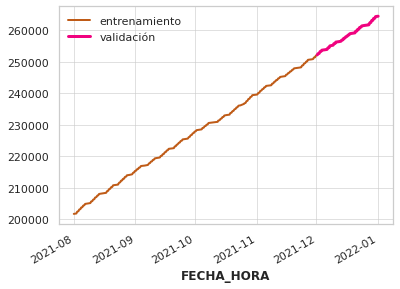

In [ ]:
train.plot(label='entrenamiento')
val.plot(label='validación', lw=3)

plt.legend()

1.1 Probamos varios modelos con parámetros por defecto para tener un primer enfoque de cual se puede aplicar mejor a nuestro anális. Se calcula para cada caso el M.A.P.E (Mean absolute percentage error)

In [ ]:
def evaluar_modelo(model):
    model.fit(train)
    prediccion = model.predict(len(val))
    #print('Modelo {} obtuvo MAPE: {:.2f}%'.format(model, mape(val, prediccion)))
    return prediccion

In [ ]:
prediccion_LM         = evaluar_modelo(LinearRegressionModel(lags=1))
#15:56 minutos

In [ ]:
prediccion_exp_sm     = evaluar_modelo(ExponentialSmoothing(seasonal=SeasonalityMode.NONE, random_state=0))
#00:09 segundos

In [ ]:
#prediccion_prophet    = evaluar_modelo(Prophet())
prediccion_arima      = evaluar_modelo(AutoARIMA())
#15 minutos

In [ ]:
prediccion_theta      = evaluar_modelo(Theta())
#05:00 minutos

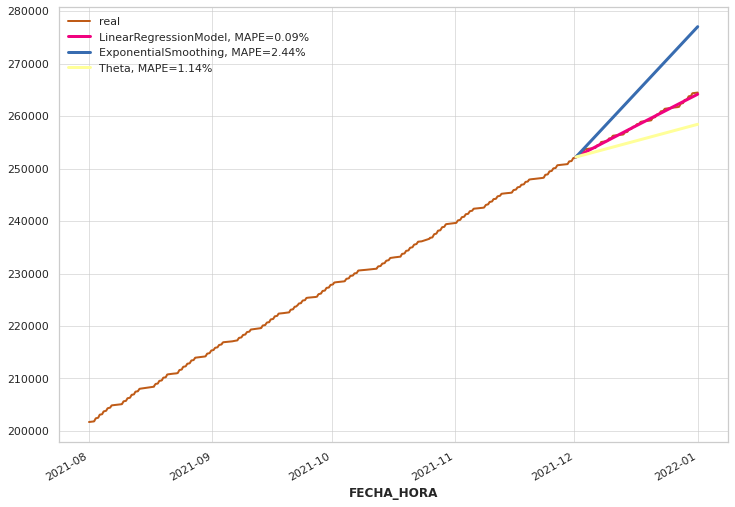

In [ ]:
fig = plt.figure(figsize=(12, 8))
series.plot(label='real')

prediccion_LM.plot(label='LinearRegressionModel, MAPE={:.2f}%'.format(mape(val, prediccion_LM)), lw=3)
prediccion_exp_sm.plot(label='ExponentialSmoothing, MAPE={:.2f}%'.format(mape(val, prediccion_exp_sm)), lw=3)
#prediccion_prophet.plot(label='Prophet, MAPE={:.2f}%'.format(mape(val, prediccion_prophet)), lw=3)
#prediccion_arima.plot(label='AutoARIMA, MAPE={:.2f}%'.format(mape(val, prediccion_arima)), lw=3)
prediccion_theta.plot(label='Theta, MAPE={:.2f}%'.format(mape(val, prediccion_theta)), lw=3)

plt.legend()

**Conclusión**: podemos observar que  de Regresión Lineal aplica perfecto a la estimación del consumo